In [41]:
import distrax
import haiku as hk
from jax import numpy as jnp, random
import optax
from sbi import SNL
from functools import partial
from surjectors.bijectors.masked_coupling import MaskedCoupling
from surjectors.conditioners.mlp import mlp_conditioner
from surjectors.distributions.transformed_distribution import TransformedDistribution
from surjectors.surjectors.chain import Chain
from surjectors.util import make_alternating_binary_mask
from sbi.mcmc.sample import sample_with_nuts, mcmc_diagnostics

import matplotlib.pyplot as plt

In [11]:
def prior_model_fns():
    p = distrax.Uniform(jnp.full(2, -3.0), jnp.full(2, 3.0))
    return p.sample, p.log_prob


def simulator_fn(seed, theta):
    p = distrax.MultivariateNormalDiag(
        theta, 0.1 * jnp.ones_like(theta)
    )
    y = p.sample(seed=seed)
    return y

def log_density_fn(theta, y):
    prior = distrax.Uniform(jnp.full(2, -3.0), jnp.full(2, 3.0))
    likelihood = distrax.MultivariateNormalDiag(
        theta, 0.1 * jnp.ones_like(theta)
    )
    
    lp = jnp.sum(prior.log_prob(theta)) + jnp.sum(likelihood.log_prob(y))
    return lp

In [3]:
def make_model(dim):
    def _bijector_fn(params):
        means, log_scales = jnp.split(params, 2, -1)
        return distrax.ScalarAffine(means, jnp.exp(log_scales))

    def _flow(method, **kwargs):
        layers = []
        for i in range(2):
            mask = make_alternating_binary_mask(dim, i % 2 == 0)
            layer = MaskedCoupling(
                mask=mask,
                bijector=_bijector_fn,
                conditioner=mlp_conditioner([8, 8, dim * 2]),
            )
            layers.append(layer)
        chain = Chain(layers)

        base_distribution = distrax.Independent(
            distrax.Normal(jnp.zeros(dim), jnp.ones(dim)),
            reinterpreted_batch_ndims=1,
        )
        td = TransformedDistribution(
            base_distribution,
            chain
        )
        return td(method, **kwargs)

    td = hk.transform(_flow)
    td = hk.without_apply_rng(td)
    return td

In [13]:
y_observed = jnp.full(2, 2)
y_observed

Array([2, 2], dtype=int32, weak_type=True)

In [20]:
log_density_fn = partial(log_density_fn, y=y_observed)
log_density = lambda x: log_density_fn(**x)

In [35]:
rng_seq = hk.PRNGSequence(0)
theta = sample_with_nuts(rng_seq, log_density, 2, 4, 2000, 1000)

In [36]:
diags = mcmc_diagnostics(theta)
diags= diags[1]

In [37]:
theta = theta.reshape(-1, 2)

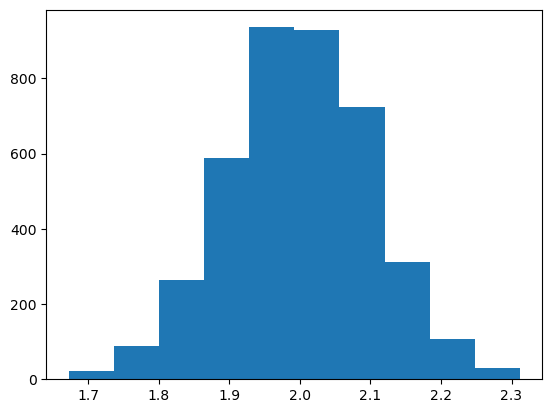

In [43]:
plt.hist(theta[:, 1])
plt.show()

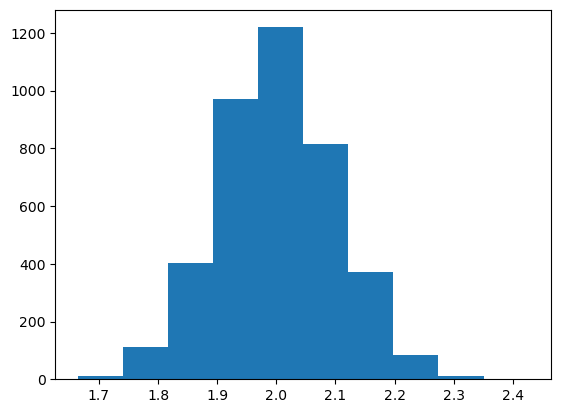

In [44]:
plt.hist(theta[:, 0])
plt.show()

In [4]:
prior_simulator_fn, prior_logdensity_fn = prior_model_fns()
fns = ((prior_simulator_fn, prior_logdensity_fn), simulator_fn)

In [45]:
model = make_model(2)

In [46]:
snl = SNL(fns, model)

In [ ]:
optimizer = optax.adam(1e-4)
params, info = snl.train(
    random.PRNGKey(23),
    jnp.full(2, 2),
    optimizer
)

In [9]:
all_losses

[Array([[4718.1777 ,  240.56569],
        [4714.863  ,  240.4003 ],
        [4711.5645 ,  240.23389],
        ...,
        [3777.0798 ,  196.2034 ],
        [3777.0796 ,  196.20325],
        [3777.0786 ,  196.2031 ]], dtype=float32),
 Array([[4704.621  ,  260.09253],
        [4701.3154 ,  259.89764],
        [4698.0273 ,  259.70255],
        [4694.723  ,  259.50626],
        [4691.394  ,  259.30838],
        [4688.0356 ,  259.1087 ],
        [4684.6445 ,  258.90692],
        [4681.217  ,  258.70288],
        [4677.75   ,  258.49646],
        [4674.241  ,  258.28754],
        [4670.6895 ,  258.07587],
        [4667.092  ,  257.8615 ],
        [4663.447  ,  257.6443 ],
        [4659.754  ,  257.42416],
        [4656.0107 ,  257.201  ],
        [4652.2163 ,  256.9748 ],
        [4648.369  ,  256.74548],
        [4644.469  ,  256.51294],
        [4640.5146 ,  256.2772 ],
        [4636.505  ,  256.03818],
        [4632.44   ,  255.79587],
        [4628.3184 ,  255.5502 ],
        [4624.139 